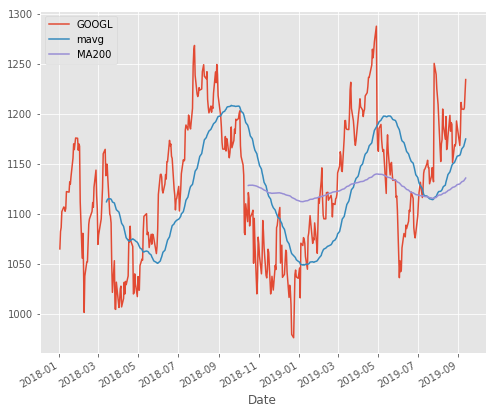

In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

#get the historical data
    # set timeframe

start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2019, 9, 12)

#get data

df = web.DataReader("GOOG", 'yahoo', start, end)
df.tail(3)

#moving average establishing
close_px = df['Adj Close']
mavg50 = close_px.rolling(window=50).mean()
mav200 = close_px.rolling(window=200).mean()

#plot MA with stock data
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='GOOGL')
mavg50.plot(label='mavg')
mav200.plot(label='MA200')
plt.legend()

dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] -df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0


import math
import numpy as np
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#used scikit v0.19.1 -> cross_validation deprecated >0.20
from  sklearn import cross_validation 
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

d:\Profiles\fuhlmann\AppData\Local\Programs\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:

from sklearn.linear_model import TheilSenRegressor, SGDRegressor, RANSACRegressor

#work with ThielSenRegressor
tsReg = TheilSenRegressor()
tsReg_fit = tsReg.fit(X_train, y_train)

#work with SDGRegressor

clfSDG = SGDRegressor(max_iter=1000, tol=1e-3)
clfSDG_fit = clfSDG.fit(X_train, y_train)

#work with RANSACRegressor

clfRANSAC = RANSACRegressor(random_state=0).fit(X_train, y_train)
clfRANSAC_fit = clfRANSAC.fit(X_train, y_train)

In [4]:
confidencetsReg = tsReg_fit.score(X_test, y_test)
confidencetsSDG = clfSDG_fit.score(X_test, y_test)
confidencetsRASNAC = clfRANSAC_fit.score(X_test, y_test)

print(confidencetsReg , confidencetsSDG, confidencetsRASNAC)

0.632086234371215 0.6312074955537272 0.5084601722734401


In [5]:
#forecasts

#1
forecast_set_TheilSen = tsReg_fit.predict(X_lately)
dfreg['Forecast TheilSen'] = np.nan

#2
forecast_set_SDGReg = clfSDG_fit.predict(X_lately)
dfreg['Forecast SDGReg'] = np.nan

#3
forecast_set_RASNAC = clfRANSAC_fit.predict(X_lately)
dfreg['Forecast RASNAC'] = np.nan



In [6]:

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

#add forecasted values of TheilSenRegression to dataframe and fill columns of forecast of other regressions with 0
for i in forecast_set_TheilSen:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-3)]+ [i] +[0] + [0]
    
#replace 0 in column 'Forecast SDGReg' with forecasted valued
z=5
for i in forecast_set_SDGReg:
    dfreg.iloc[len(dfreg)-z,6] = i
    z = z-1
#replace 0 in column 'Forecast RASNAC' with forecasted valued
z=5
for j in forecast_set_RASNAC:
    dfreg.iloc[len(dfreg)-z,7] = j
    z= z-1

[]

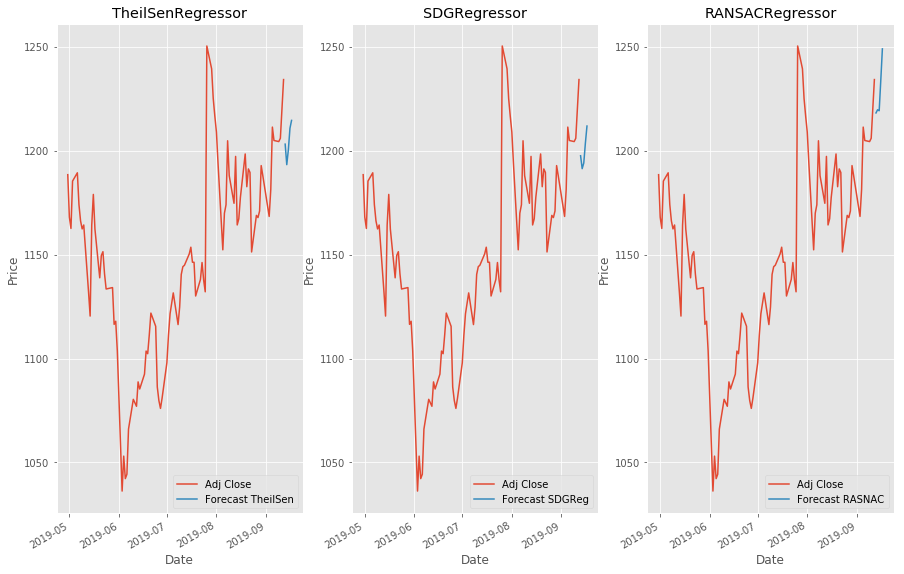

In [7]:
plt.subplots_adjust(hspace=1.4,wspace=0.5)

plt.figure(figsize=(15,10)) 

plt.subplot(1,3,1)
dfreg['Adj Close'].tail(100).plot()
dfreg['Forecast TheilSen'].tail(100).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('TheilSenRegressor')

plt.subplot(1,3,2)
dfreg['Adj Close'].tail(100).plot()
dfreg['Forecast SDGReg'].tail(100).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SDGRegressor')

plt.subplot(1,3,3)
dfreg['Adj Close'].tail(100).plot()
dfreg['Forecast RASNAC'].tail(100).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('RANSACRegressor')



plt.plot()